## Initializations

Data from: https://www.kaggle.com/mansoordaku/ckdisease

In [59]:
## Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re

### Lifelines
import lifelines as lf

## Statistics
import scipy.stats as sc_stats

## Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV

### Methods for classification 
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression

### Model selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

### Methods for regression
from sklearn.linear_model import LinearRegression

### For feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

warnings.filterwarnings('ignore')

### Parameters

In [2]:
pvalue_th = 0.05
seed_th = 0

### Functions 

In [3]:
def check_end_or_begin_with(list_strings, word, mode="end"):
    correct_result = list()
    for f in list_strings:
        if mode == "end" and f.endswith(word):
            correct_result.append(f)
        elif mode == "start" and f.startswith(word):
            correct_result.append(f)
        else:
            if mode != "end" and mode != "start":
                print("Choose between end or start mode")
    return correct_result

In [4]:
def auc_scorer(clf, X, y, model): 
    
    fpr, tpr, _ = roc_curve( y, clf.decision_function(X) ) 
        
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, 
             label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

    return fpr,tpr,roc_auc

def obtain_stats(col_x):
    dict_result = dict()
    
    dict_result["min"] = np.nanmin( col_x )
    dict_result["perct25"] = np.nanpercentile( col_x, 25 )
    dict_result["mean"] = np.nanmean( col_x )
    dict_result["median"] = np.nanmedian( col_x )
    dict_result["std"] = np.nanstd( col_x )
    dict_result["perct75"] = np.nanpercentile( col_x, 75 )
    dict_result["max"] = np.nanmax( col_x )
    
    return dict_result

## Data and Exploratory Data Analysis

In [5]:
df = pd.read_csv('data/kidney_disease.csv')

print( "Columns name", df.columns.values )

print("Number of columns", df.shape[1])
print("Number of patients", df.shape[0])
print( "Data frame shape", df.shape )

Columns name ['id' 'age' 'bp' 'sg' 'al' 'su' 'rbc' 'pc' 'pcc' 'ba' 'bgr' 'bu' 'sc'
 'sod' 'pot' 'hemo' 'pcv' 'wc' 'rc' 'htn' 'dm' 'cad' 'appet' 'pe' 'ane'
 'classification']
Number of columns 26
Number of patients 400
Data frame shape (400, 26)


In [6]:
type_var_dict = dict()
for col in df.columns:
    type_var_dict[col] = df[col].dtype.name
    
print("Table of variables type")
var_type_df = pd.DataFrame(type_var_dict, index=[0])
print( var_type_df )

print("Number of variable of type int64", np.sum(var_type_df.T == "int64"))
print("Number of variable of type float64", np.sum(var_type_df.T == "float64"))
print("Number of variable of type object", np.sum(var_type_df.T == "object"))

Table of variables type
      id      age       bp       sg       al       su     rbc      pc     pcc  \
0  int64  float64  float64  float64  float64  float64  object  object  object   

       ba  ...     pcv      wc      rc     htn      dm     cad   appet  \
0  object  ...  object  object  object  object  object  object  object   

       pe     ane classification  
0  object  object         object  

[1 rows x 26 columns]
Number of variable of type int64 0    1
dtype: int64
Number of variable of type float64 0    11
dtype: int64
Number of variable of type object 0    14
dtype: int64


## Data cleaning 

In [7]:
problem_columns = ["pcv", "wc", "rc", "dm", "cad", "classification"]
characters = ["\t"]
for col in problem_columns:
    
    new_colum_list = list()
    for val in df[col].values:
            
        try:    
            if "\t?" in val:
                new_colum_list.append( np.nan )

            elif "\t" in val:
                x = re.sub("\t", "")
                new_colum_list.append( x )

            else:
                new_colum_list.append( val )
        except:
            new_colum_list.append( np.nan )
            
    df[col] = new_colum_list

columns_numeric = ["pcv", "wc", "rc"]
for col in columns_numeric:
    df[col] = pd.to_numeric( df[col] )

## Statistics 

In [8]:
for col in df.columns:
    if df[col].dtype == "object":
        print("Column", col)
        cat_val_dict = dict()
        for cat_values in set( df[col].values ):
            if isinstance(cat_values, str):
                perct = 100*np.sum(df[col].values == cat_values)/df.shape[0]
                cat_val_dict[cat_values] = perct
            elif np.isnan(cat_values):
                nona_samples = df[col].dropna().shape[0]
                total_samples = df.shape[0]
                perct = 100*(total_samples-nona_samples)/total_samples
                cat_val_dict[cat_values] = perct
                
        print( set(df[col].values), cat_val_dict )

Column rbc
{nan, 'abnormal', 'normal'} {nan: 38.0, 'abnormal': 11.75, 'normal': 50.25}
Column pc
{nan, 'abnormal', 'normal'} {nan: 16.25, 'abnormal': 19.0, 'normal': 64.75}
Column pcc
{'present', nan, 'notpresent'} {'present': 10.5, nan: 1.0, 'notpresent': 88.5}
Column ba
{'present', nan, 'notpresent'} {'present': 5.5, nan: 1.0, 'notpresent': 93.5}
Column htn
{nan, 'yes', 'no'} {nan: 0.5, 'yes': 36.75, 'no': 62.75}
Column dm
{nan, 'yes', ' yes', 'no'} {nan: 1.75, 'yes': 33.5, ' yes': 0.25, 'no': 64.5}
Column cad
{nan, 'yes', 'no'} {nan: 1.0, 'yes': 8.5, 'no': 90.5}
Column appet
{nan, 'good', 'poor'} {nan: 0.25, 'good': 79.25, 'poor': 20.5}
Column pe
{nan, 'yes', 'no'} {nan: 0.25, 'yes': 19.0, 'no': 80.75}
Column ane
{nan, 'yes', 'no'} {nan: 0.25, 'yes': 15.0, 'no': 84.75}
Column classification
{nan, 'notckd', 'ckd'} {nan: 0.5, 'notckd': 37.5, 'ckd': 62.0}


In [9]:
dict_nan_col = dict( np.sum(df.isna()) )
print( "Dictionary of nans per column", dict_nan_col )

rate_nan = 0.2

good_columns = list()

for key in dict_nan_col.keys():
    if dict_nan_col[key] <= rate_nan*df.shape[0]:
        good_columns.append( key )

Dictionary of nans per column {'id': 0, 'age': 9, 'bp': 12, 'sg': 47, 'al': 46, 'su': 49, 'rbc': 152, 'pc': 65, 'pcc': 4, 'ba': 4, 'bgr': 44, 'bu': 19, 'sc': 17, 'sod': 87, 'pot': 88, 'hemo': 52, 'pcv': 72, 'wc': 108, 'rc': 131, 'htn': 2, 'dm': 7, 'cad': 4, 'appet': 1, 'pe': 1, 'ane': 1, 'classification': 2}


### Numerical distributions

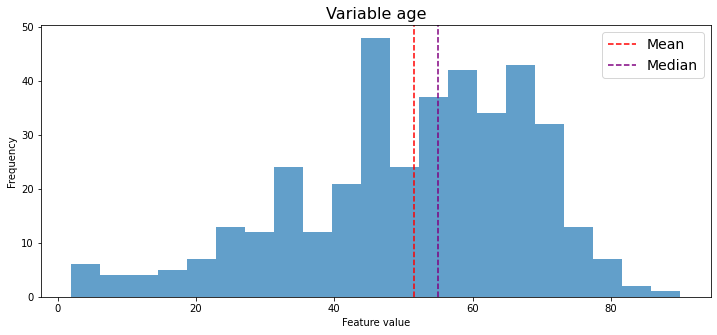

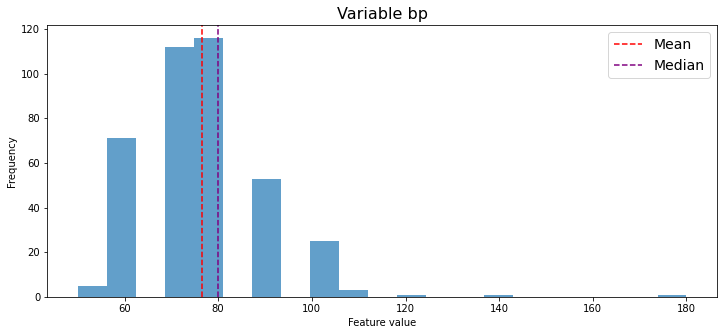

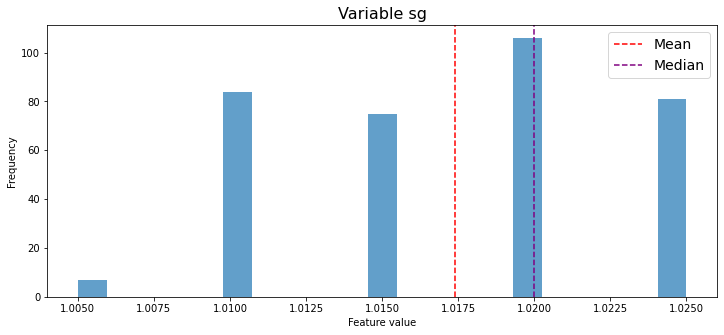

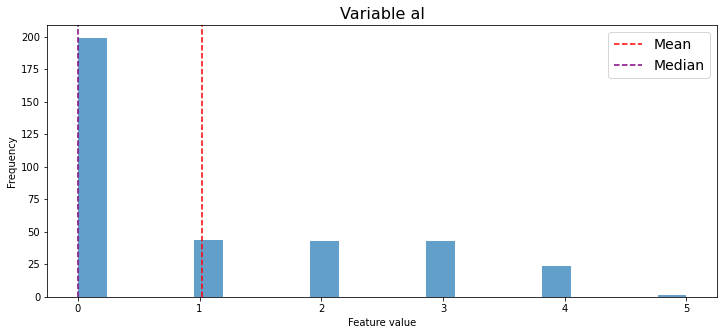

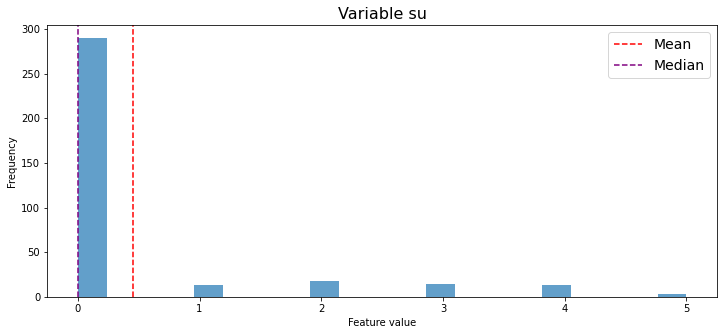

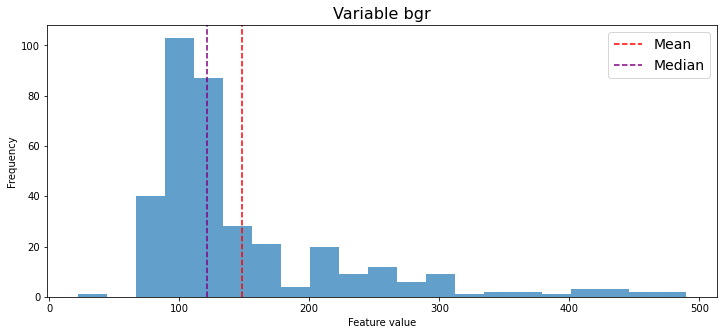

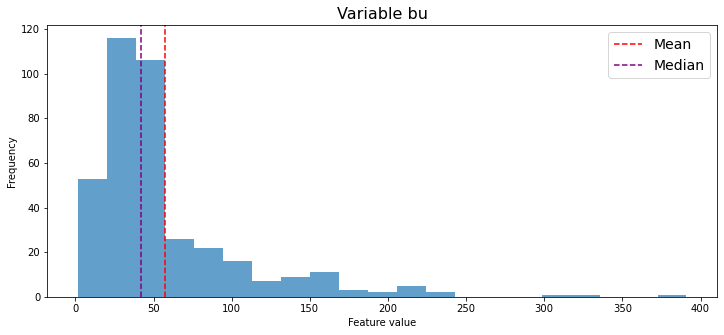

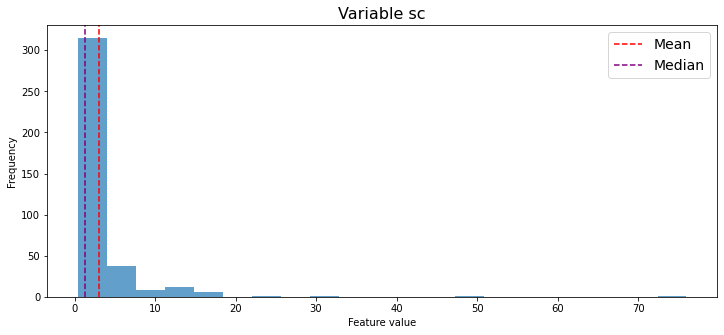

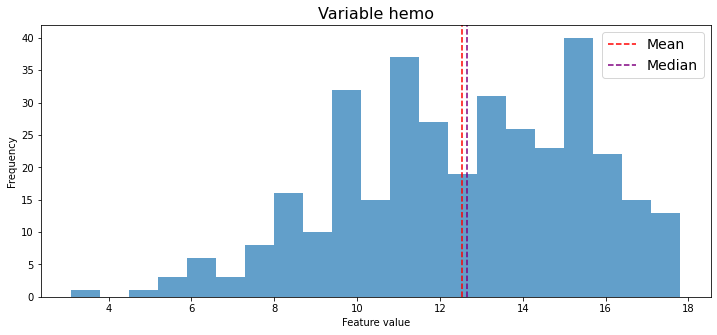

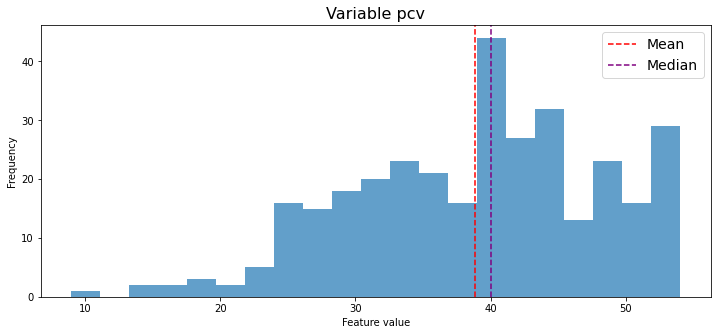

In [10]:
dict_stats_num = {"col":[], "statistic":[], "normal_distr":[], "pvalue_normal":[], 
                  "n_nans":[], "perc_nans":[],
                  "min":[], "perct25":[], "mean":[], "median":[], "std":[], "perct75":[], "max":[]}

for col in good_columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and col != "id":
        
        plt.figure(figsize=(12, 5))
        
        plt.hist( df[col], bins=21, alpha=0.7 )
        plt.title("Variable "+col, fontsize=16)
        
        plt.axvline( np.nanmean(df[col]), color="red", linestyle="--",label="Mean" )
        plt.axvline( np.nanmedian(df[col]), color="purple", linestyle="--",label="Median" )
        
        plt.ylabel("Frequency")
        plt.xlabel("Feature value")
        
        plt.legend(fontsize=14)
        
        plt.show()
        
        stats_dict = obtain_stats( df[col].values )
        
        k, pvalue = sc_stats.normaltest( df[col].dropna().values )
        if pvalue > pvalue_th:
            normal_distr = "Normal"
        else:
            normal_distr = "Not-Normal"
        
        dict_stats_num["col"].append( col )
        dict_stats_num["statistic"].append( k )
        dict_stats_num["normal_distr"].append( normal_distr )
        dict_stats_num["pvalue_normal"].append( pvalue )
        dict_stats_num["n_nans"].append( np.sum(np.isnan(df[col].values)) )
        dict_stats_num["perc_nans"].append( 100*np.sum(np.isnan(df[col].values))/df.shape[0] )
        dict_stats_num["min"].append( stats_dict["min"] )
        dict_stats_num["perct25"].append( stats_dict["perct25"] )
        dict_stats_num["mean"].append( stats_dict["mean"] )
        dict_stats_num["median"].append( stats_dict["median"] )
        dict_stats_num["std"].append( stats_dict["std"] )
        dict_stats_num["perct75"].append( stats_dict["perct75"] )
        dict_stats_num["max"].append( stats_dict["max"] )

In [11]:
stats_num_df = pd.DataFrame(dict_stats_num)
stats_num_df

,col,statistic,normal_distr,pvalue_normal,n_nans,perc_nans,min,perct25,mean,median,std,perct75,max
0,age,25.308087,Not-Normal,3.194617e-06,9,2.25,2.000,42.00,51.483376,55.00,17.147744,64.50,90.000
1,bp,165.604015,Not-Normal,1.095330e-36,12,3.00,50.000,70.00,76.469072,80.00,13.665993,80.00,180.000
2,sg,145.436230,Not-Normal,2.623758e-32,47,11.75,1.005,1.01,1.017408,1.02,0.005709,1.02,1.025
3,al,46.866977,Not-Normal,6.652200e-11,46,11.50,0.000,0.00,1.016949,0.00,1.350767,2.00,5.000
4,su,184.714086,Not-Normal,7.759715e-41,49,12.25,0.000,0.00,0.450142,0.00,1.097624,0.00,5.000
5,bgr,152.594863,Not-Normal,7.318911e-34,44,11.00,22.000,99.00,148.036517,121.00,79.170285,163.00,490.000
6,bu,235.627959,Not-Normal,6.823997e-52,19,4.75,1.500,27.00,57.425722,42.00,50.436685,66.00,391.000
7,sc,558.648180,Not-Normal,4.910084e-122,17,4.25,0.400,0.90,3.072454,1.30,5.733626,2.80,76.000
8,hemo,11.595309,Not-Normal,3.034664e-03,52,13.00,3.100,10.30,12.526437,12.65,2.908399,15.00,17.800
9,pcv,11.492661,Not-Normal,3.194481e-03,72,18.00,9.000,32.00,38.871951,40.00,8.987224,45.00,54.000


In [12]:
print( "Percentage of normal distributed values", 
      100*np.sum(stats_num_df["normal_distr"] == "Normal")/stats_num_df.shape[0], "%" )

Percentage of normal distributed values 0.0 %


### Statics and distributions

In [13]:
dict_mw_stats = {"col1":[], "col2":[], "pvalue":[]}
for i, col1 in enumerate(good_columns):
    for col2 in good_columns[:]:
        if pd.api.types.is_numeric_dtype( df[col1] ) and col1 != "id":
            if pd.api.types.is_numeric_dtype( df[col2] ) and col2 != "id":
                if col1 != col2:
                    df_nona_numeric = df[[col1, col2]].dropna()
                    stc, pvalue = sc_stats.mannwhitneyu(df_nona_numeric[col1].values, 
                                                        df_nona_numeric[col2].values)
                    dict_mw_stats["col1"].append(col1)
                    dict_mw_stats["col2"].append(col2)
                    dict_mw_stats["pvalue"].append(pvalue)

In [14]:
df_mw_stats = pd.DataFrame(dict_mw_stats)

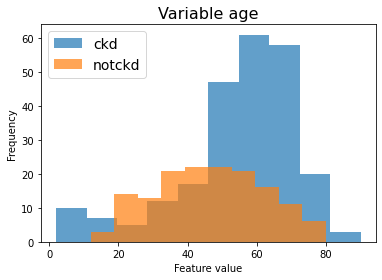

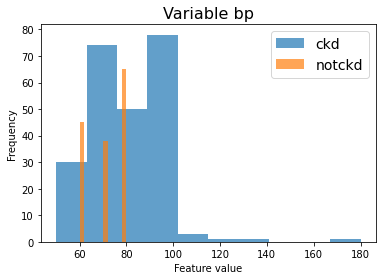

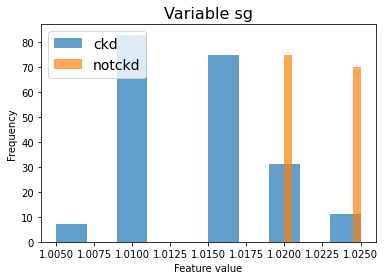

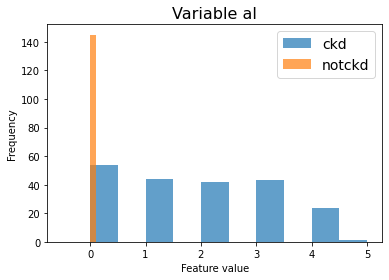

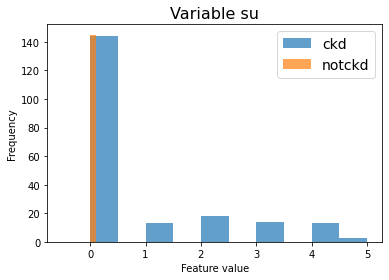

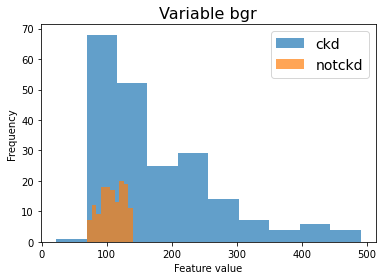

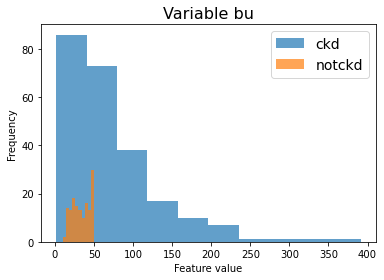

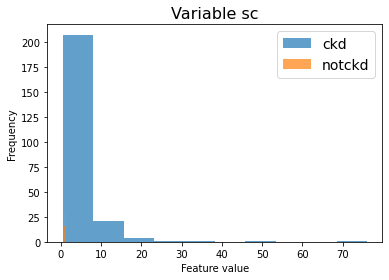

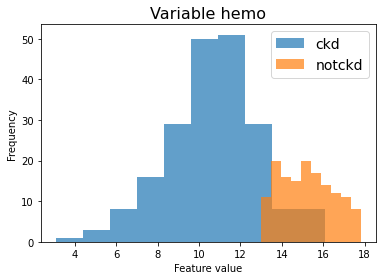

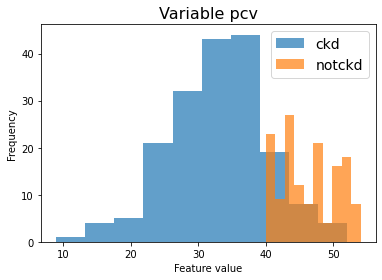

In [15]:
dict_clf = {"Variable":[], "pvalue":[]}
for i, col in enumerate(good_columns):
    if pd.api.types.is_numeric_dtype( df[col] ) and col != "id":
        val_x = df[df["classification"] == "ckd"][col].dropna().values
        val_y = df[df["classification"] == "notckd"][col].dropna().values
        stc, pvalue = sc_stats.mannwhitneyu(val_x, val_y)
        
        dict_clf["Variable"].append(col)
        dict_clf["pvalue"].append(pvalue)
        
        plt.hist( val_x, label="ckd", alpha=0.7 )
        plt.hist( val_y, label="notckd", alpha=0.7 )
        plt.title("Variable "+col, fontsize=16)
        
        plt.ylabel("Frequency")
        plt.xlabel("Feature value")
        
        plt.legend(fontsize=14)
        
        plt.show()

In [16]:
pd.DataFrame(dict_clf)

,Variable,pvalue
0,age,2.910788e-08
1,bp,5.924953e-09
2,sg,3.889667e-44
3,al,1.441392e-39
4,su,3.585394e-13
5,bgr,2.334969e-15
6,bu,6.484815e-17
7,sc,6.042192e-44
8,hemo,2.249668e-50
9,pcv,1.684569e-45


### Column transformation

In [92]:
transf_list_name = ["log1p", "sqrt", "inverse", "square", "exp"]
def inverse(x):
    return 1/x
def square(x):
    return x**2
func_list = [np.log1p, np.sqrt, inverse, square, np.exp]

In [93]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and "id" not in col and "num_clf" not in col:
        for ct_i, func in enumerate(func_list):
            x = list(map(func, df[col].dropna().values))
            
            k, pvalue = sc_stats.normaltest( x )
            #print(pvalue)
            if pvalue > pvalue_th:
                print("Variable", col, "is normal with transformation:", transf_list_name[ct_i])
            

Variable bp is normal with transformation: inverse
Variable bp_imp_median is normal with transformation: inverse
Variable pcv_imp_median is normal with transformation: square


### Correlation plot 

In [17]:
corr_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]) )
pvalue_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]) )
star_mat = np.zeros( (stats_num_df.shape[0], stats_num_df.shape[0]),dtype=object )

for i, col_i in enumerate(stats_num_df["col"].values):
    for j, col_j in enumerate(stats_num_df["col"].values):
        idx_values = df[[col_i, col_j]].dropna().index.values
        
        col_i_values = df[col_i].iloc[idx_values].values
        col_j_values = df[col_j].iloc[idx_values].values
        
        corrp, pvalue = sc_stats.pearsonr(col_i_values, col_j_values)
        
        corr_mat[i,j] = corrp
        pvalue_mat[i,j] = pvalue
        
        if pvalue >= 0.05:
            star_mat[i,j] = "-"
        elif 0.01 <= pvalue < 0.05:
            star_mat[i,j] = "*"
        elif 0.001 <= pvalue < 0.01:
            star_mat[i,j] = "**"
        elif pvalue < 0.001:
            star_mat[i,j] = "***"

In [18]:
corr_df = pd.DataFrame(corr_mat)
corr_df.columns = stats_num_df["col"].values
corr_df.index = stats_num_df["col"].values
corr_df.style.background_gradient(cmap='coolwarm')

,age,bp,sg,al,su,bgr,bu,sc,hemo,pcv
age,1.000000,0.159480,-0.191096,0.122091,0.220866,0.244992,0.196985,0.132531,-0.192928,-0.243951
bp,0.159480,1.000000,-0.218836,0.160689,0.222576,0.160193,0.188517,0.146222,-0.306540,-0.326871
sg,-0.191096,-0.218836,1.000000,-0.469760,-0.296234,-0.374710,-0.314295,-0.361473,0.602582,0.604604
al,0.122091,0.160689,-0.469760,1.000000,0.269305,0.379464,0.453528,0.399198,-0.634632,-0.611596
su,0.220866,0.222576,-0.296234,0.269305,1.000000,0.717827,0.168583,0.223244,-0.224775,-0.238764
bgr,0.244992,0.160193,-0.374710,0.379464,0.717827,1.000000,0.143322,0.114875,-0.306189,-0.302003
bu,0.196985,0.188517,-0.314295,0.453528,0.168583,0.143322,1.000000,0.586368,-0.610360,-0.607320
sc,0.132531,0.146222,-0.361473,0.399198,0.223244,0.114875,0.586368,1.000000,-0.401670,-0.403903
hemo,-0.192928,-0.306540,0.602582,-0.634632,-0.224775,-0.306189,-0.610360,-0.401670,1.000000,0.895347
pcv,-0.243951,-0.326871,0.604604,-0.611596,-0.238764,-0.302003,-0.607320,-0.403903,0.895347,1.000000


In [19]:
pvalue_df = pd.DataFrame(pvalue_mat)
pvalue_df.columns = stats_num_df["col"].values
pvalue_df.index = stats_num_df["col"].values
pvalue_df.style.background_gradient(cmap='coolwarm')

,age,bp,sg,al,su,bgr,bu,sc,hemo,pcv
age,0.000000,0.001843,0.000344,0.022732,0.000035,0.000004,0.000131,0.010295,0.000339,0.000010
bp,0.001843,0.000000,0.000044,0.002800,0.000034,0.002727,0.000261,0.004658,0.000000,0.000000
sg,0.000344,0.000044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
al,0.022732,0.002800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
su,0.000035,0.000034,0.000000,0.000000,0.000000,0.000000,0.002023,0.000038,0.000064,0.000029
bgr,0.000004,0.002727,0.000000,0.000000,0.000000,0.000000,0.007157,0.031426,0.000000,0.000000
bu,0.000131,0.000261,0.000000,0.000000,0.002023,0.007157,0.000000,0.000000,0.000000,0.000000
sc,0.010295,0.004658,0.000000,0.000000,0.000038,0.031426,0.000000,0.000000,0.000000,0.000000
hemo,0.000339,0.000000,0.000000,0.000000,0.000064,0.000000,0.000000,0.000000,0.000000,0.000000
pcv,0.000010,0.000000,0.000000,0.000000,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
star_df = pd.DataFrame(star_mat)
star_df.columns = stats_num_df["col"].values
star_df.index = stats_num_df["col"].values
star_df

,age,bp,sg,al,su,bgr,bu,sc,hemo,pcv
age,***,**,***,*,***,***,***,*,***,***
bp,**,***,***,**,***,**,***,**,***,***
sg,***,***,***,***,***,***,***,***,***,***
al,*,**,***,***,***,***,***,***,***,***
su,***,***,***,***,***,***,**,***,***,***
bgr,***,**,***,***,***,***,**,*,***,***
bu,***,***,***,***,**,**,***,***,***,***
sc,*,**,***,***,***,*,***,***,***,***
hemo,***,***,***,***,***,***,***,***,***,***
pcv,***,***,***,***,***,***,***,***,***,***


## Survival analysis

In [21]:
mapping = {"ckd":1, "notckd":0}
df["num_clf"] = df.replace({"classification":mapping})["classification"]

In [22]:
col_to_model = list(stats_num_df["col"].values)+["num_clf"]
df_nona_num = df[col_to_model].dropna()

In [23]:
cph_fit = lf.CoxPHFitter().fit(df_nona_num, 
                               duration_col="age", 
                               event_col="num_clf")

In [24]:
cph_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 259 total observations, 130 right-censored observations>
             duration col = 'age'
                event col = 'num_clf'
      baseline estimation = breslow
   number of observations = 259
number of events observed = 129
   partial log-likelihood = -523.07
         time fit was run = 2021-02-28 12:04:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
bp          0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
sg        -62.39       0.00      21.34          -104.21           -20.57                 0.00                 0.00
al          0.10       1.11       0.09            -0.07             0.27                 0.94                 1.31
su         -0.11       0.90       0.10            -0.30             0.09                 0.74                 1.09
bgr         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
bu         -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
sc          0.02       1.02       0.03            -0.04             0.07                 0.96                 1.08
hemo       -0.18       0.83       0.13            -0.43             0.07                 0.65                 1.07
pcv         0.01       1.01       0.04            -0.07             0.08                 0.94                 1.08

              z      p   -log2(p)
covariate                        
bp         0.73   0.46       1.11
sg        -2.92 <0.005       8.18
al         1.20   0.23       2.11
su        -1.08   0.28       1.83
bgr        1.17   0.24       2.05
bu        -0.77   0.44       1.18
sc         0.51   0.61       0.71
hemo      -1.44   0.15       2.73
pcv        0.14   0.89       0.18
---
Concordance = 0.70
Partial AIC = 1064.13
log-likelihood ratio test = 68.11 on 9 df
-log2(p) of ll-ratio test = 34.70

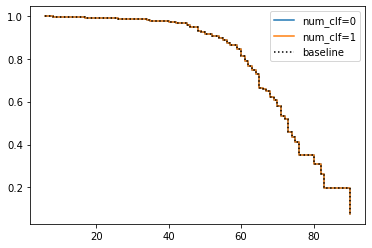

In [25]:
cph_fit.plot_partial_effects_on_outcome(covariates="num_clf", values=[0,1])

Number of knots 2


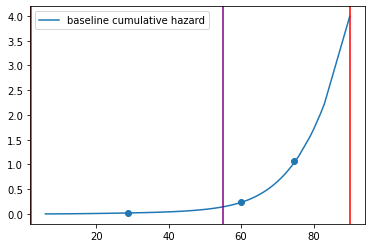

Number of knots 3


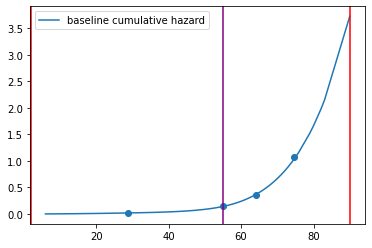

In [26]:
list_of_knots = np.arange(2, 4)
for n_knots in list_of_knots:
    cph_fit_spline = lf.CoxPHFitter(baseline_estimation_method="spline", 
                                    n_baseline_knots=n_knots)
    cph_fit_spline.fit(df_nona_num, 
                       duration_col="age", 
                       event_col="num_clf")
    df_spline = cph_fit_spline.baseline_cumulative_hazard_
    all_points = cph_fit_spline.baseline_cumulative_hazard_.index
    
    knt_x_list = list()
    knt_y_list = list()
    for knt in cph_fit_spline.knots:
        idx_pt = np.argsort( np.abs(all_points-knt) )[0]
        knt_x_list.append(knt)

        knt_y = df_spline["baseline cumulative hazard"].values[idx_pt]
        knt_y_list.append(knt_y)

    print("Number of knots", n_knots)
    cph_fit_spline.baseline_cumulative_hazard_.plot()
    plt.scatter(knt_x_list, knt_y_list)
    
    plt.axvline([np.nanmin(df["age"])], color = "red")
    plt.axvline([np.nanmax(df["age"])], color = "red")
    plt.axvline([np.nanmedian(df["age"])], color = "purple")

    plt.show()

In [27]:
df_summary = cph_fit_spline.print_summary()

<lifelines.CoxPHFitter: fitted with 259 total observations, 130 right-censored observations>
             duration col = 'age'
                event col = 'num_clf'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 259
number of events observed = 129
           log-likelihood = -537.41
         time fit was run = 2021-02-28 12:04:34 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param covariate                                                                                                         
beta_ bp          0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
      sg        -10.31       0.00      20.46           -50.41            29.79                 0.00             8.62e+12
      al          0.07       1.07       0.09            -0.10             0.24                 0.90                 1.27
      su         -0.07       0.93       0.10            -0.27             0.13                 0.77                 1.14
      bgr         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
      bu         -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
      sc          0.03       1.04       0.03            -0.02             0.09                 0.98                 1.10
      hemo       -0.23       0.80       0.12            -0.46             0.01                 0.63                 1.01
      pcv         0.00       1.00       0.03            -0.06             0.07                 0.94                 1.07
      Intercept   2.68      14.56      20.67           -37.83            43.19                 0.00             5.72e+18
phi1_ Intercept   1.82       6.18       0.53             0.78             2.86                 2.18                17.55
phi2_ Intercept -13.12       0.00      13.78           -40.13            13.89                 0.00             1.07e+06
phi3_ Intercept   7.46    1744.59      23.50           -38.60            53.53                 0.00             1.76e+23

                    z      p   -log2(p)
param covariate                        
beta_ bp         0.86   0.39       1.36
      sg        -0.50   0.61       0.70
      al         0.79   0.43       1.22
      su        -0.68   0.50       1.01
      bgr        1.54   0.12       3.01
      bu        -1.21   0.23       2.13
      sc         1.16   0.25       2.02
      hemo      -1.89   0.06       4.07
      pcv        0.11   0.91       0.13
      Intercept  0.13   0.90       0.16
phi1_ Intercept  3.42 <0.005      10.65
phi2_ Intercept -0.95   0.34       1.55
phi3_ Intercept  0.32   0.75       0.41
---
AIC = 1100.83
log-likelihood ratio test = 10806.51 on 9 df
-log2(p) of ll-ratio test = inf

## Imputation

In [28]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype( df[col] ) and col != "id" and col != "num_clf":
        if np.sum(np.isnan(df[col].values)) > 0:
            df[col+"_imp_median"] = df[col].fillna( df[col].median() )

## Clasification

In [40]:
col_median_imp = check_end_or_begin_with(df.columns, "median", mode="end")
print("Columns imputed by median:", len(col_median_imp), "which are:", col_median_imp)
col_normal = list()
for col in df.columns:
    if "median" not in col and "id" not in col and "num_clf" not in col:
        if pd.api.types.is_numeric_dtype( df[col] ):
            col_normal.append(col)
print("Columns not imputed:", len(col_normal), "which are:", col_normal)

Columns imputed by median: 14 which are: ['age_imp_median', 'bp_imp_median', 'sg_imp_median', 'al_imp_median', 'su_imp_median', 'bgr_imp_median', 'bu_imp_median', 'sc_imp_median', 'sod_imp_median', 'pot_imp_median', 'hemo_imp_median', 'pcv_imp_median', 'wc_imp_median', 'rc_imp_median']
Columns not imputed: 14 which are: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']


In [74]:
dataset_name = ["Normal", "Median_imputed"]
columns_to_model = [col_normal, col_median_imp]
target_list = ["num_clf"]

models_list = [LogisticRegression()]
name_models_list = ["LGR"]
grid_search_list = [None]

In [75]:
folds_th = 10
n_rep_th = 4

rskf = RepeatedStratifiedKFold(n_splits=folds_th, 
                              n_repeats=n_rep_th, 
                              random_state=seed_th)
for tar in target_list:
    print("Studying target:", tar)
    
    for ct_i, col in enumerate(columns_to_model):
        
        print("Using dataset", dataset_name[ct_i])
        df_nona_model = df[[tar]+col].dropna()
        print("Shape of the dataset", df_nona_model.shape)
        
        X = df_nona_model[col]
        Y = df_nona_model[tar]
            
        for ct_m, model in enumerate(models_list):
            print("Using model", name_models_list[ct_m])
            
            sfs1 = SFS(model, k_features=10, 
                           forward=False, floating=False, 
                           verbose=0, cv=rskf, n_jobs=-1,
                           scoring="accuracy")

            X_new = sfs1.fit_transform(X, Y)
            
            acc_list = list()
            kappa_list = list()
            
            for train_idx, test_idx in rskf.split(X_new, Y):
            
                xtrain, ytrain = X_new[train_idx], Y.values[train_idx]
                xtest, ytest = X_new[test_idx], Y.values[test_idx]
                
                model.fit(xtrain, ytrain)
                ypred = model.predict(xtest)
                
                acc = accuracy_score(ytest, ypred)
                acc_list.append(acc)
                
                kappa = cohen_kappa_score(ytest, ypred)
                kappa_list.append(kappa)
            
            print("Accuracy = ", np.round(np.nanmean(acc_list),2), "+/-", np.round(np.nanstd(acc_list),2))
            print("Kappa = ", np.round(np.nanmean(kappa_list),2), "+/-", np.round(np.nanstd(kappa_list),2))
            
            print("*"*50)

Studying target: num_clf
Using dataset Normal
Shape of the dataset (201, 15)
Using model LGR
Accuracy =  0.99 +/- 0.02
Kappa =  0.98 +/- 0.04
**************************************************
Using dataset Median_imputed
Shape of the dataset (398, 15)
Using model LGR
Accuracy =  0.97 +/- 0.02
Kappa =  0.95 +/- 0.05
**************************************************


## Regression